<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Load extra stuff
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data

# Adrian: Found from earlier testing/iteration that 'Id' column in CSV already contains running number.
# Use this column as index for dataframe to avoid redundancy.
house = pd.read_csv('./housing.csv', index_col='Id')


In [3]:
# A:   
# Get shape of raw housing data
print("Number of rows in housing.csv: {}".format(house.shape[0]))
print("Number of cols in housing.csv: {}\n".format(house.shape[1]))

# Resizing print option to see all columns at once
pd.set_option('max_columns', 82)
pd.set_option('max_rows', 82)

# Have a rough idea what the columns contain
print(house.info())

Number of rows in housing.csv: 1460
Number of cols in housing.csv: 80

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null 

#### Adrian's Comments:
There are 80 columns to work with. Per project instructions, we want to predict price eventually, so the last column 'SalePrice' will be the target. That leaves with 79 columns as candidates for the design matrix.

In [4]:
# Identify and segregate which column(s) store numeric or string/object values
numeric_cols = list(house.describe(exclude='object').columns)
string_cols =  list(house.describe(include='object').columns)

In [5]:
# First things first. Let's check the zone type for this dataframe.
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

#### Adrian's Comments:
We are only interested in residential properties, so the 10 'C' entries representing commercial property will be excluded. 'FV' is considered 'residential' per the description, so it will be retained. The rest are all residential type so they will be retained.

In [6]:
# Take a quick peek at these commercial properties, and more importantly, their indices
house[house['MSZoning']=='C (all)']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,6,1910,1998,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Rec,1046,Unf,0,168,1214,GasW,Ex,N,SBrkr,1260,1031,0,2291,0,1,2,0,4,2,TA,9,Typ,1,Gd,Detchd,1900.0,Unf,2,506,TA,TA,Y,0,0,0,0,99,0,NaN,NaN,NaN,0,11,2007,WD,Normal,133900
496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,GasA,TA,N,FuseA,720,0,0,720,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,523,115,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
558,50,C (all),60.0,11040,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,6,1920,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,637,Unf,0,0,637,GasA,Gd,Y,SBrkr,897,439,0,1336,0,0,1,1,3,1,TA,7,Typ,0,NaN,CarPort,1994.0,Unf,1,570,TA,TA,Y,0,47,120,0,0,0,NaN,NaN,NaN,0,9,2006,COD,Normal,108000
712,50,C (all),66.0,8712,Pave,Pave,Reg,HLS,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,7,1900,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Stone,TA,TA,Mn,Unf,0,Unf,0,859,859,GasA,Gd,Y,SBrkr,859,319,0,1178,0,0,1,0,2,1,TA,7,Typ,0,NaN,Detchd,1964.0,RFn,1,384,TA,TA,N,68,0,98,0,0,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,102776
813,20,C (all),66.0,8712,Grvl,NaN,Reg,Bnk,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,5,5,1952,1952,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,TA,CBlock,TA,TA,Av,Unf,0,Unf,0,540,540,GasA,TA,N,FuseA,1044,0,0,1044,0,0,1,0,2,1,Fa,4,Typ,0,NaN,Basment,1952.0,Unf,2,504,TA,TA,N,0,0,0,0,0,0,NaN,NaN,Shed,54,6,2010,WD,Alloca,55993
917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,GasA,TA,N,FuseA,480,0,0,480,1,0,0,0,1,1,TA,4,Typ,0,NaN,Detchd,1958.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,35311
1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,3,4,1935,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,Fa,TA,CBlock,TA,TA,No,Unf,0,Unf,0,894,894,GasA,TA,Y,SBrkr,894,0,0,894,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1994.0,RFn,3,1248,TA,TA,Y,0,20,0,0,0,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000


In [7]:
# Identify the index labels to drop, then discard those 10 rows
commercial = house[house['MSZoning']=='C (all)'].index
print(commercial) # Just to double confirm the row index to drop
house.drop(commercial, inplace = True)

Int64Index([31, 89, 94, 496, 558, 712, 813, 917, 1062, 1280], dtype='int64', name='Id')


In [8]:
# We should have 1450 rows left
house.shape

(1450, 80)

#### Adrian's Comments: Define 'Fixed' vs 'Renovate-able' features

Using the data description, we need to identify 'fixed' features vs 'renovate-able' features.
We define 'renovate-able' as attributes that the houseowner or contractors can reasonably change.
Features that require significant structural changes like hacking walls or alter column/foundation, 
or those that cannot be changed at all like zoning or terrain will be classified as 'fixed'.

In [9]:
# Create lists of 'fixed' and 'renovate-able' features
fixed = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street',
         'Alley','LotShape','LandContour','Utilities','LotConfig',
         'LandSlope','Neighborhood','Condition1','Condition2',
         'BldgType','HouseStyle','YearBuilt','YearRemodAdd',
         'MasVnrType','MasVnrArea','Foundation','BsmtQual',
         'BsmtExposure','TotalBsmtSF','1stFlrSF','2ndFlrSF',
         'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
         'FullBath','HalfBath','Bedroom','Kitchen','TotRmsAbvGrd',
         'Fireplaces','GarageType','GarageYrBlt','GarageCars',
         'GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF',
         'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
         'MiscFeature','MiscVal','MoSold','YrSold','SaleType',
         'SaleCondition']
renovate = ['OverallQual','OverallCond','RoofStyle','RoofMatl',
            'Exterior1st','Exterior2nd','ExterQual','ExterCond',
            'BsmtCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2',
            'BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC',
            'CentralAir','Electrical','KitchenQual','Functional',
            'FireplaceQu','GarageFinish','GarageQual','GarageCond',
            'PoolQC','Fence']

## Data Cleaning

In [10]:
# Next is to do data cleaning. Check empty/NaN cells first.
NA_result = house.isnull().sum()
# Identify column(s) that contains NaN and their respective counts
NA_result[NA_result.values>0]

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

#### Adrian's Comments:
We will need to do some cleaning/processing for the above 19 columns/variables that contain NaN values.<br>
In addition, Alley/FireplaceQu/PoolQC/Fence/MiscFeature have unusually high amount of NaN (>50% within their respective columns). We need to look into these to decide if it is worth retaining these columns for further analysis.

In [11]:
# Fix NaN for 'LotFrontage'. Check out the distribution.
house['LotFrontage'].describe()

count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [12]:
# It is unlikely that a house is not connected to a street (i.e. no 'LotFrontage'), so it might be a typo.
# 'LotFrontage' has a huge outlier of 313, so better to convert NaN to median instead.
house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace=True)

In [13]:
# Per the data description, 'NA' is defined as 'No alley access', it is converted to NaN by mistake.
# Manually change it back to 'NA' category
house['Alley'].fillna('NA', inplace=True)

In [14]:
# Per the data description, there is no 'NA' category defined for 'MasVnrType'. The 8 NaN values are unintended.
# Take a look at the distribution of the values in this column
print(house['MasVnrType'].value_counts())
# See the percentage of the distribution
for i in range(len(house['MasVnrType'].value_counts())):
    print("{}\t\t{}".format(house['MasVnrType'].value_counts().index[i], 
                          house['MasVnrType'].value_counts()[i]*100/len(house)))

None       854
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
None		58.89655172413793
BrkFace		30.689655172413794
Stone		8.827586206896552
BrkCmn		1.0344827586206897


In [15]:
# Rows with NaN for 'MasVnrType' also have the same NaN for 'MasVnrArea'
# Both needs to be fixed concurrently
house[house['MasVnrType'].isnull()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN


In [16]:
# 'None' has the most values in 'MasVnrType' (854 or 58.9%). Change NaNs to the mode.
house['MasVnrType'].fillna('None', inplace=True)

# Following the reason in 'MasVnrType', if it is set to 'None' then it should have 0 area.
house['MasVnrArea'].fillna(0, inplace=True)

In [17]:
# Let's look at 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' as they are all related.
# Per the data description, 'NA' is defined as 'No Basement', it is converted to NaN by mistake.
# Manually change it back to 'NA' category
house['BsmtQual'].fillna('NA', inplace=True)
house['BsmtCond'].fillna('NA', inplace=True)
house['BsmtExposure'].fillna('NA', inplace=True)
house['BsmtFinType1'].fillna('NA', inplace=True)
house['BsmtFinType2'].fillna('NA', inplace=True)

In [18]:
# Let's look at 'Electrical' distribution
house['Electrical'].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [19]:
# Majority of the values (1328 or 91.5%) are 'SBrkr', so just set the only NaN value to the mode.
house['Electrical'].fillna('SBrkr', inplace=True)

In [20]:
# Let's look at 'FireplaceQu' distribution
house['FireplaceQu'].value_counts()

Gd    379
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [21]:
# Per the data description, 'NA' is defined as 'No Fireplace', it is converted to NaN by mistake.
# Manually change it back to 'NA' category
house['FireplaceQu'].fillna('NA', inplace=True)

In [22]:
# Let's look at 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond' as they are all related.
# Per the data description, 'NA' is defined as 'No Garage', it is converted to NaN by mistake.
# Manually change it back to 'NA' category
# 'GarageYrBlt' is a numerical year value. There is no 'year' if it is not built in the first place.
# Let's check out the distribution for this column
house['GarageYrBlt'].describe()

count    1371.000000
mean     1978.627279
std        24.592779
min      1906.000000
25%      1961.500000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [23]:
# The oldest garage is built in 1906. We'll declare '0' as sentinel value to indicate this property's
# garage was never built in the first place (i.e. 'No Garage')
# Now we can amend the NaN for all these 5 'garage' columns
house['GarageType'].fillna('NA', inplace=True)
house['GarageYrBlt'].fillna(0, inplace=True)
house['GarageFinish'].fillna('NA', inplace=True)
house['GarageQual'].fillna('NA', inplace=True)
house['GarageCond'].fillna('NA', inplace=True)

In [24]:
# Let's look at 'PoolQC', 'Fence', 'MiscFeature'
# Per the data description, 'NA' is defined as 'No Pool', 'No Fence' and 'None' respectively.
# It is converted to NaN by mistake, so we manually change it back to 'NA' category
house['PoolQC'].fillna('NA', inplace=True)
house['Fence'].fillna('NA', inplace=True)
house['MiscFeature'].fillna('NA', inplace=True)


#### This concludes the section on handling NaN in the dataset.

In [25]:
# 'LotArea' and 'SalePrice' have large values. Need to rescale it to manageable range.
house[['LotArea','SalePrice']].describe()

,LotArea,SalePrice
count,1450.000000,1450.000000
mean,10523.831724,181654.942069
std,10012.185355,79176.485241
min,1300.000000,37900.000000
25%,7544.500000,130000.000000
50%,9496.000000,163945.000000
75%,11613.500000,214000.000000
max,215245.000000,755000.000000


In [26]:
# We will scale down these 2 variables to units of thousands; make it easier to read and handle
house[['LotArea','SalePrice']] = house[['LotArea','SalePrice']] / 1000

In [27]:
# The following columns are categorical variables with an overwhelmingly dominant value (>80% or more).
# Also we identified earlier some of these columns are mostly NA/NaN values.
# Since they provide no useful insight, we choose to drop these columns.

house.drop('Street', inplace=True, axis=1)
house.drop('Alley', inplace=True, axis=1)
house.drop('Utilities', inplace=True, axis=1)
house.drop('Condition2', inplace=True, axis=1)
house.drop('PoolArea', inplace=True, axis=1)
house.drop('PoolQC', inplace=True, axis=1)
# house.drop('FireplaceQu', inplace=True, axis=1) # The dominance of this variable is marginal, exclude for now.
# house.drop('Fence', inplace=True, axis=1) # The dominance of this variable is marginal, exclude for now.
house.drop('MiscFeature', inplace=True, axis=1)
house.drop('MiscVal', inplace=True, axis=1)

# It is unlikely that 'MSSubClass' and 'MSZoning' in itself is a major consideration for a potential buyer.
# We will drop these columns too.
house.drop('MSSubClass', inplace=True, axis=1)
house.drop('MSZoning', inplace=True, axis=1)

# From inspection, we deduce the following relationship
# BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF
# 1stFlrSF + 2ndFlrSF + LowQualFinSF = GrLivArea
# Potential buyers typically consider the total floor area rather than the breakdown of individual component.
# So we will just consider 'TotalBsmtSF' and 'GrLivArea' only. We consider the other variables as 'multicollinear'.

house.drop('BsmtFinSF1', inplace=True, axis=1)
house.drop('BsmtFinSF2', inplace=True, axis=1)
house.drop('BsmtUnfSF', inplace=True, axis=1)
house.drop('1stFlrSF', inplace=True, axis=1)
house.drop('2ndFlrSF', inplace=True, axis=1)
house.drop('LowQualFinSF', inplace=True, axis=1)

# Let's see how many columns are left
house.shape

(1450, 64)

In [28]:
# We look at the relationship of the numerical columns w.r.t 'SalePrice'
house.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).head(15)

,SalePrice
SalePrice,1.000000
OverallQual,0.789031
GrLivArea,0.708658
GarageCars,0.642135
GarageArea,0.629831
TotalBsmtSF,0.612088
FullBath,0.556674
TotRmsAbvGrd,0.533355
YearBuilt,0.517602
YearRemodAdd,0.501186


In [29]:
# We will just consider columns/variables with correlation > 0.5.
# 'GarageCars' is highly correlated to 'GarageArea'. We'll drop one of them
col_num = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF',
           'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd']

# Create a subset dataframe that consists of shortlisted numerical columns only
house_num = house[col_num]
house_num

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,
1,7,1710,2,856,2,8,2003,2003
2,6,1262,2,1262,2,6,1976,1976
3,7,1786,2,920,2,6,2001,2002
4,7,1717,3,756,1,7,1915,1970
5,8,2198,3,1145,2,9,2000,2000
6,5,1362,2,796,1,5,1993,1995
7,8,1694,2,1686,2,7,2004,2005
8,7,2090,2,1107,2,7,1973,1973
9,7,1774,2,952,2,8,1931,1950


In [30]:
# Identify columns containing categorical variables
col_cat =  list(house.describe(include='object').columns)

In [31]:
# For now, we will just look at variables with 'FIXED' attributes
col_cat_fixed = [c for c in col_cat if c in fixed]
col_cat_fixed # Just to double confirm which columns got shortlisted

['LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'MasVnrType',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'GarageType',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [32]:
# Create a subset that consists of the shortlisted categorical columns only
# Then prepare a dataframe for modelling
house_merge = pd.concat([house_num, pd.get_dummies(house[col_cat_fixed], prefix=col_cat_fixed, 
                                                   drop_first=True)], axis=1)

# Put in the target variable column, prepare dataframe for modelling
house_model = pd.concat([house_merge, house['SalePrice']], axis=1)

# We set 2010 data as test set. Everything else will go to training set.
house_test = house_model[house['YrSold']==2010]
house_train = house_model[house['YrSold']!=2010]

# 'SalePrice' is target variable y, we need to take it out just before modelling
cols = list(house_model.columns)
cols.remove('SalePrice')

# Prepare the design matrix and target vector
X_train = house_train[cols]
y_train = house_train['SalePrice'].values
X_test = house_test[cols]
y_test = house_test['SalePrice'].values

In [33]:
# Perform modelling
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X_train, y_train)


In [34]:
# Check the predicted values for y
y_pred = selector.predict(X_test)
residual = y_test - y_pred
y_pred

array([154.79457565, 142.28352996, 140.69688927, 320.91061453,
       172.6898897 , 127.28227782, 295.73756869, 121.01000859,
       141.69902748, 257.87100101,  75.07841689, 146.4255694 ,
        97.02769483, 131.13426455,  74.11023116, 118.38628587,
       195.8605577 , 188.17357232, 199.14670689, 194.34891695,
       185.00371637, 303.73026149,  93.72640451, 136.7353637 ,
       220.27779911, 286.52716194, 227.22561889, 259.42506276,
       206.41543881, 125.62357127, 164.51946382, 135.49053854,
        95.6651977 , 143.82750348, 133.17541126, 197.51699226,
       194.25115904, 212.08517574, 136.60678899, 248.14644307,
       223.68484042, 118.72437362, 137.51591032, 126.19024874,
       326.00498936, 231.88589396, 111.32530693, 118.41103609,
       262.12218985, 223.88599597,  97.59960435, 118.28179599,
       129.64047193, 159.4994866 , 109.30743359, 368.66868182,
       136.33492548, 173.71960917, 127.65783763, 294.5826928 ,
       115.96545446, 126.78056721, 202.26604282, 242.85

In [35]:
# Check the R2 score
selector.score(X_test,y_test)

0.8602321581858584

In [36]:
# Check what columns/features are returned by RFECV()
rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

array(['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath',
       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'LotShape_IR2',
       'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veen

#### Adrian's Comments:
RFECV() performed feature selection on the design matrix, identifying the above variables as having large impact on predicting house prices. Our model obtained an R2 score of 0.86

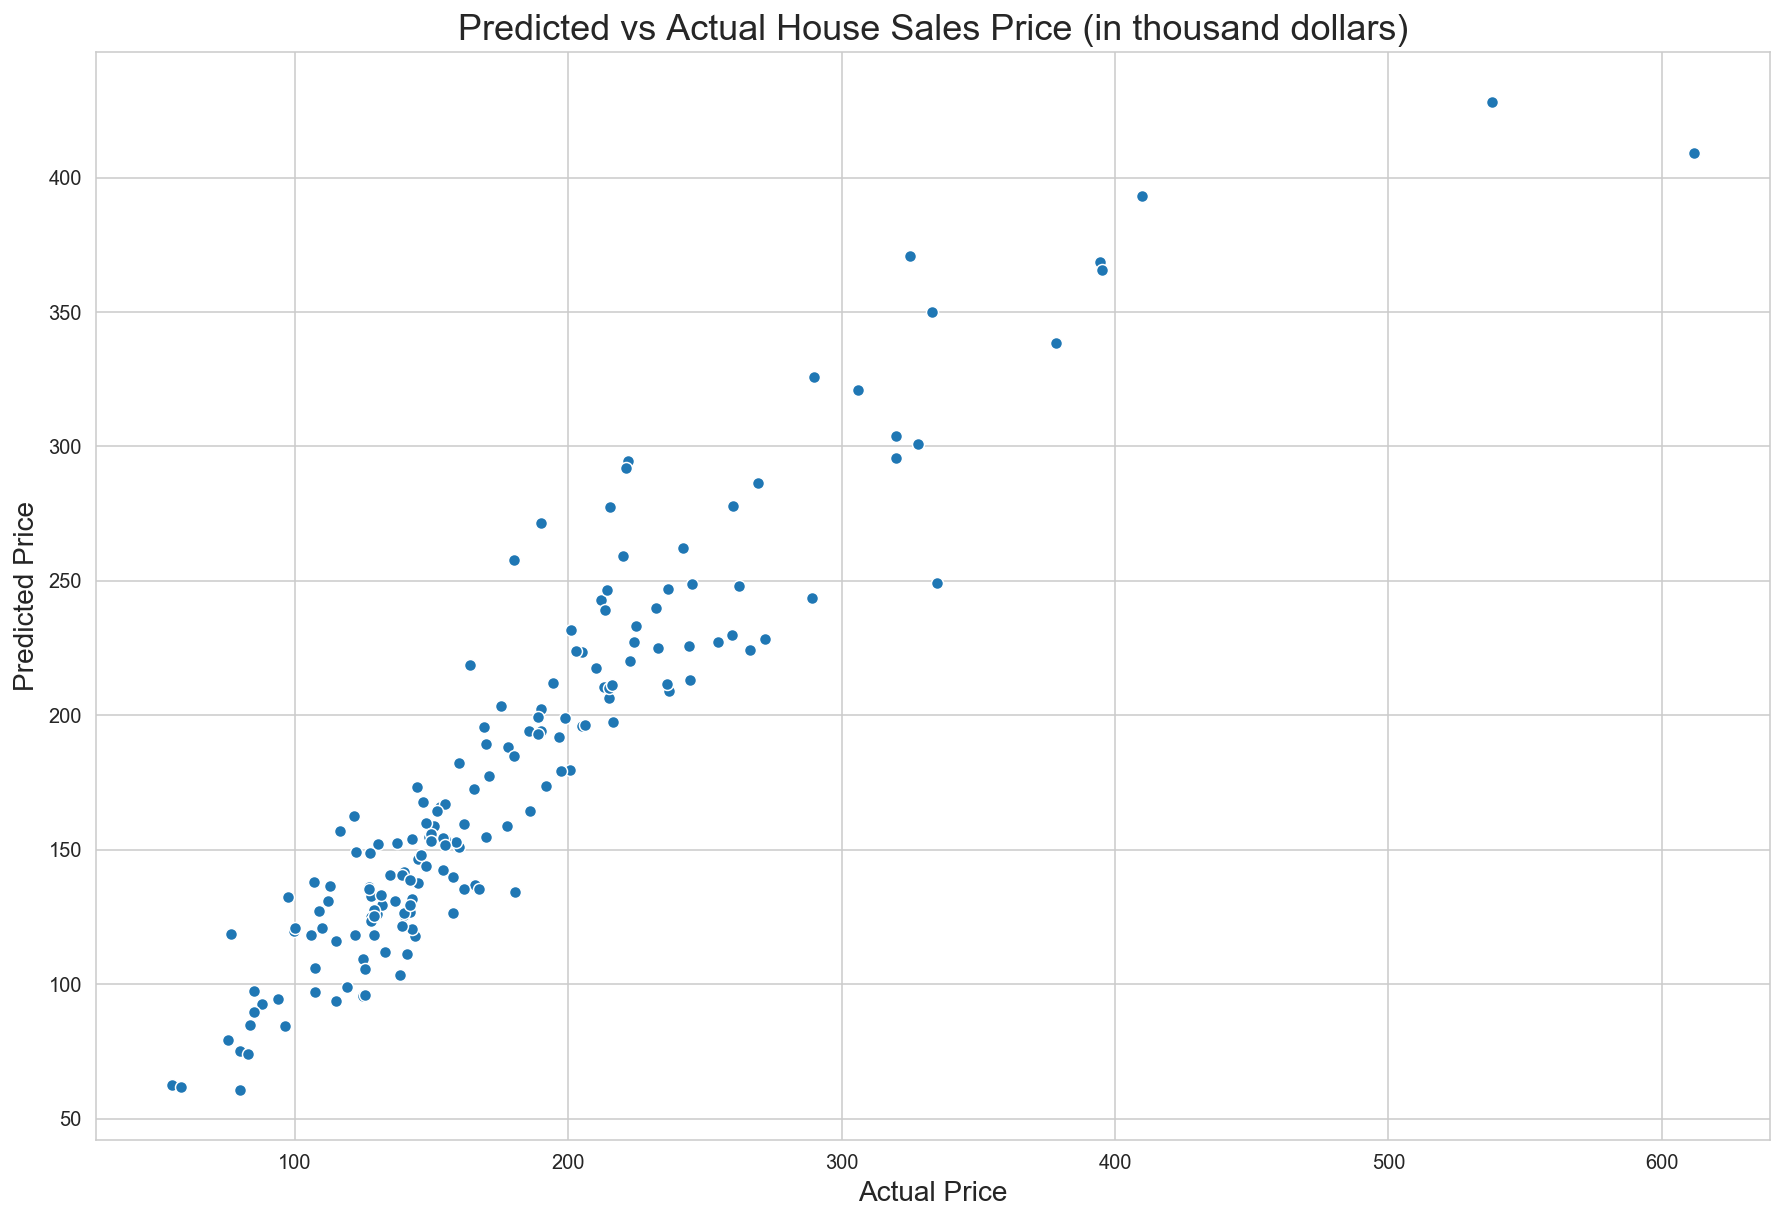

In [37]:
# Take a visual look on the model
plt.figure(figsize=(15, 10))
plt.title('Predicted vs Actual House Sales Price (in thousand dollars)', fontsize=18)
ax = sns.scatterplot(y_test, y_pred)
ax.set_xlabel('Actual Price', fontsize=14)
ax.set_ylabel('Predicted Price', fontsize=14)
plt.show()

#### Adrian's Comments:
It seems that our model (predicted sales price) is tracking the actual sales price quite nicely and linearly.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [38]:
# A:
# For this section, we need to consider the 'renovate-able' part of the house price prediction modelling

In [39]:
# Quick recap on the 'renovate-able' columns/variables that were defined earlier
print(renovate)
len(renovate)

['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']


26

In [40]:
# This time, we will just look at categorical variables with 'renovate-able' attributes
col_cat_renovate = [c for c in col_cat if c in renovate]
print(col_cat_renovate) # Just to double confirm which columns got shortlisted

['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']


In [41]:
# Create a subset that consists of the shortlisted categorical columns only
# Then prepare a dataframe for modelling
house_renovate_merge = pd.concat([house_num, pd.get_dummies(house[col_cat_renovate], prefix=col_cat_renovate, 
                                                   drop_first=True)], axis=1)
# house2.drop(col_cat_renovate, inplace=True, axis=1)

# Put in the target variable column, prepare dataframe for modelling
house_model_renovate = pd.concat([house_renovate_merge, house['SalePrice']], axis=1)

# We set 2010 data as test set. Everything else will go to training set.
house_renovate_test = house_model_renovate[house['YrSold']==2010]
house_renovate_train = house_model_renovate[house['YrSold']!=2010]

# 'SalePrice' is target variable y, we need to take it out just before modelling
cols_renovate = list(house_model_renovate.columns)
cols_renovate.remove('SalePrice')

# Prepare the design matrix and target vector
X_train = house_renovate_train[cols_renovate]
y_train = house_renovate_train['SalePrice'].values
X_test = house_renovate_test[cols_renovate]
y_test = house_renovate_test['SalePrice'].values

In [42]:
# Perform modelling
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X_train, y_train)

In [43]:
# Check the predicted values for y
y_pred = selector.predict(X_test)
residual = y_test - y_pred
y_pred

array([161.72135234, 171.12967202, 134.2662183 , 272.22502542,
       186.45049894, 122.20719107, 341.17682596, 116.29221285,
       173.25158092, 203.90130791,  64.54112215, 129.52544209,
       101.37326901, 102.1266181 ,  84.6816225 ,  89.9391181 ,
       181.32134908, 186.23362345, 196.18868612, 204.90857506,
       219.15616956, 293.59489527,  99.2516181 , 164.46598498,
       223.79165736, 294.34366911, 246.32908467, 229.36927245,
       217.01992647, 109.79960574, 184.96597016, 150.03591942,
       124.29654777, 124.74418068, 116.269377  , 229.25362551,
       211.09193663, 211.55401269, 148.40160615, 237.3241646 ,
       251.80732222,  71.2773022 , 110.23773765, 147.01329892,
       293.59513687, 198.39117535,  94.79035272, 111.64352613,
       254.80870123, 234.18438523,  90.72510771, 126.16224851,
       132.77345306, 181.27221595, 111.45585383, 356.50993486,
       158.60695453, 243.47415373, 113.4884691 , 275.70576686,
       105.04722942, 142.01271978, 235.34120991, 186.72

In [44]:
# Check the R2 score
selector.score(X_test,y_test)

0.8104107368320758

In [45]:
# Check what columns/features are returned by RFECV()
rfecv_columns = np.array(cols_renovate)[selector.support_]
rfecv_columns

array(['OverallQual', 'GarageCars', 'FullBath', 'TotRmsAbvGrd',
       'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior1st_CemntBd', 'Exterior1st_HdBoard',
       'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_AsphShn',
       'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other',
       'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco',
       'Exterior2nd_VinylSd', 'Exterior2nd

#### Adrian's Comments:
RFECV() performed feature selection on the design matrix, identifying the above variables as having large impact on predicting house prices. Our model obtained an R2 score of 0.81, which is slightly lower than the result obtained earlier (0.86). It seems that the renovate-able features have no positive impact on increasing house price.

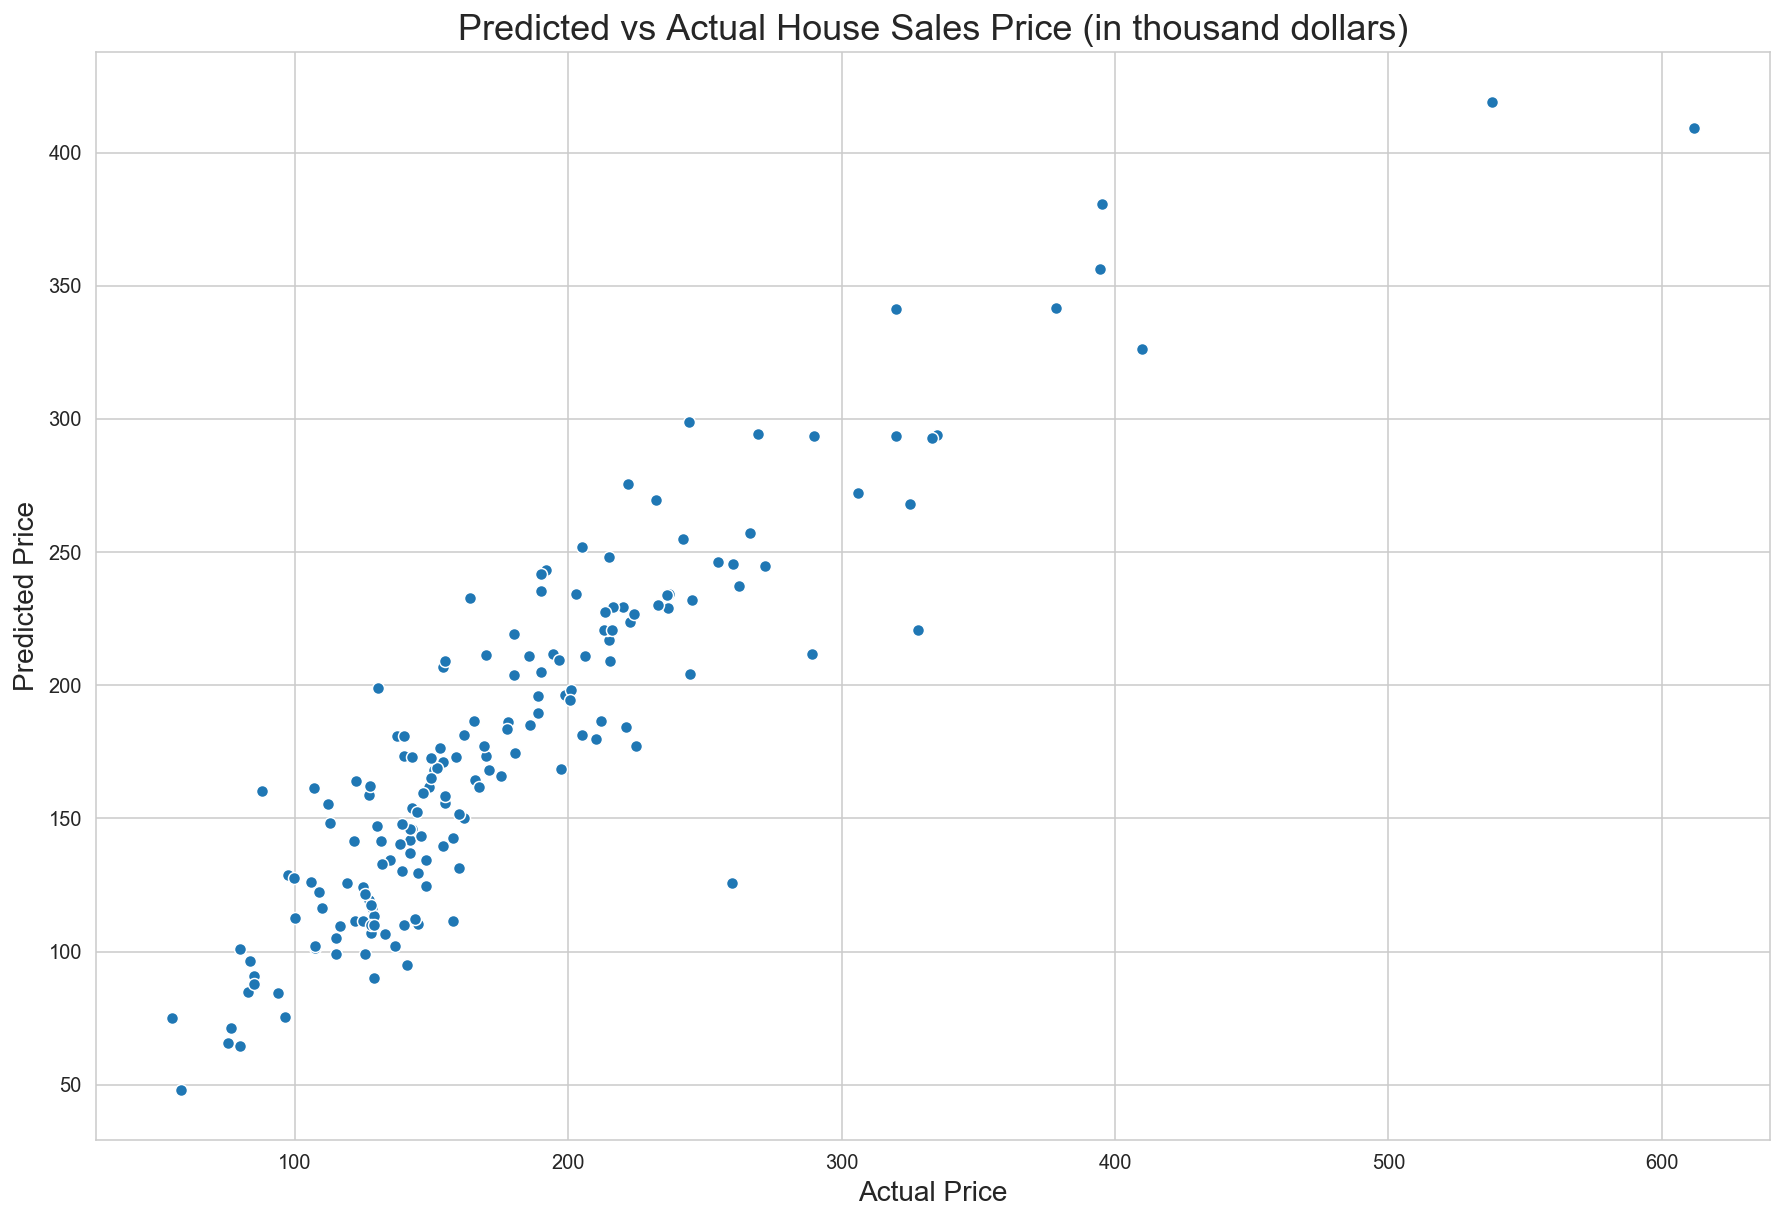

In [46]:
# Take a visual look on the model
plt.figure(figsize=(15, 10))
plt.title('Predicted vs Actual House Sales Price (in thousand dollars)', fontsize=18)
ax = sns.scatterplot(y_test, y_pred)
ax.set_xlabel('Actual Price', fontsize=14)
ax.set_ylabel('Predicted Price', fontsize=14)
plt.show()

#### Adrian's Comments:
From the above plot, we still see a strong positive correlation between actual vs predicted saleprice, so this means our revised model is still tracking the actual sale price pretty well.

A drop in score for the second model might suggest that housebuyers are less affected or persuaded by renovation factors in their decision making. It would appear that this model is not a good measure to decide which property to buy and renovate for the purpose of flipping it for higher profits.